# IEEE European Low Voltage Test Feeder: 

http://sites.ieee.org/pes-testfeeders/resources/

The current IEEE test cases are focused on North American style systems; however it is common outside of North America to see low-voltage distribution systems, both radial and meshed. It is important to make sure that tools support both dominant styles of distribution system configuration. This test case seeks to fill a benchmark gap by presenting a number of common low-voltage configurations. This circuit also introduces quasi-static time series simulations.

IEEE European LV network is a generic 0.416 kV network serviced by one 0.8 MVA MV/LV transformer and a 11kV external grid. The network supplies 906 LV buses and 55 1-PH loads. The network layout is mostly radial


# Time Series data from Benchmark dataset
In this example the time series data from benchmark is used to perform a time series load flow analysis
in pandapower

The network data from csv is used to create Powerfactory and pandapower networks.

The Sum total of power and maximum voltage is plotted with respect to 1440 time steps( 1 min interval) during the day:



# Pre-requisites :
- Load data from IEEE benchmark dataset
- pandapower network of IEEE European LV


In [1]:
import os
import numpy as np
import pandas as pd
import tempfile
import pandapower as pp
from pandapower.control import ConstControl
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.networks import ieee_european_lv_asymmetric
from pandapower import pp_dir
parent = os.path.join(pp_dir,'test','test_files')
path = parent + "\\European_LV_CSV\\"
load_path = path + "\\Load Profiles\\"
def remove_comments(f):
    '''Pass comments'''
    start=f.seek(0)
    for index in range(5):
        start=f.tell()
        if f.readline().startswith('#'):
            continue
        else:
            break      
    f.seek(start)
    return f

with open (path+"Loads.csv",'r') as f:
    f = remove_comments(f)
    loads = pd.read_csv(f)
    f.close()
    
with open (path+"LoadShapes.csv",'r') as f:
    f = remove_comments(f)
    loadshapes = pd.read_csv(f)
    f.close()

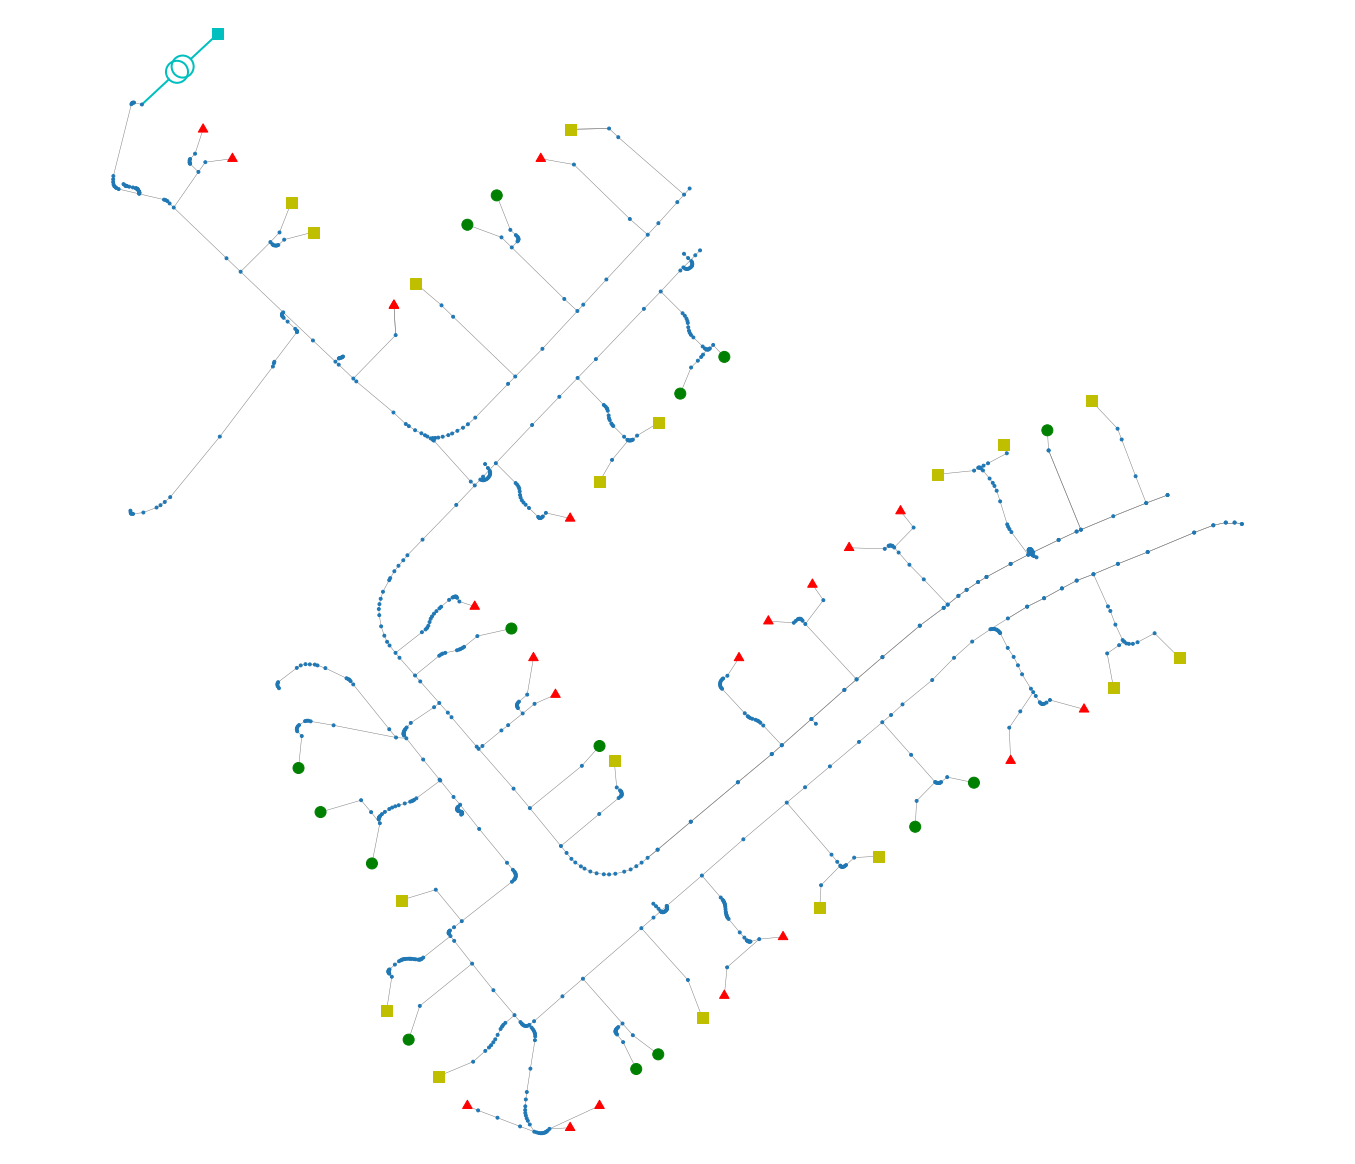

In [2]:
import pandapower.plotting as plot
net =ieee_european_lv_asymmetric('on_peak_566')
%matplotlib inline
import numpy as np
try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]

bc = plot.create_bus_collection(net, net.bus.index, size=.2, color=colors[0], zorder=10)
tlc, tpc = plot.create_trafo_collection(net, net.trafo.index, color="c",size =1.5 )
lcd = plot.create_line_collection(net, net.line.index, color="grey", linewidths=0.5, use_bus_geodata=True)
sc = plot.create_bus_collection(net, net.ext_grid.bus.values, patch_type="rect", size=.75, color="c", zorder=11)
ldA = plot.create_bus_collection(net, net.asymmetric_load.bus.values[np.where(net.asymmetric_load.p_a_mw >0)], patch_type="poly3", size=.75, color="r", zorder=11)
ldB = plot.create_bus_collection(net, net.asymmetric_load.bus.values[np.where(net.asymmetric_load.p_b_mw >0)], patch_type="rect", size=.75, color="y", zorder=11)
ldC = plot.create_bus_collection(net, net.asymmetric_load.bus.values[np.where(net.asymmetric_load.p_c_mw >0)], patch_type="circle", size=.75, color="g", zorder=11)
plot.draw_collections([lcd, bc, tlc, tpc, sc,ldA,ldB,ldC], figsize=(19,17))


- Cyan rectangle is External Grid and circle is the transformer
- Red triangles, yellow rectangles and green dots represent A,B,C phase loads respectively
- blue dots are buses
- grey lines are power lines.


# time series

Function to load time series data and perform time-series **three phase load flow**

In [3]:
def timeseries_example(output_dir):
    # 1. create test net
    net = ieee_european_lv_asymmetric('on_peak_566')
    pp.runpp_3ph(net)
    # 2. create data source for loads
    profiles, ds = create_data_source()
    # 3. create controllers (to control P values of the load and the sgen)
    net = create_controllers(net, ds)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, loadshapes.npts[0])

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps, output_writer=ow, run=pp.runpp_3ph,continue_on_divergence=True)

# Data source
Data taken from csv data provided in IEEE benchmark grid

In [4]:
def create_data_source():
    profiles = pd.DataFrame()
    for loadprofile,file in (loadshapes[['Name','File']].values):
        profiles[loadprofile] = pd.read_csv(load_path+file).mult.values*1e-3 
        profiles[loadprofile+'cos_phi'] = float(loads[loads.Yearly==loadprofile].PF.values)
    ds = DFData(profiles)
    return profiles, ds

# Time series controller
P, Q values entered using P and power factor(cos_phi) data

In [5]:
def create_controllers(net, ds):
    ConstControl(net, element='asymmetric_load', variable='p_a_mw', element_index=loads[loads['phases']=='A'].index,
                 data_source=ds, profile_name=loads[loads['phases']=='A'].Yearly)
    ConstControl(net, element='asymmetric_load', variable='p_b_mw', element_index=loads[loads['phases']=='B'].index,
                 data_source=ds, profile_name=loads[loads['phases']=='B'].Yearly)
    ConstControl(net, element='asymmetric_load', variable='p_c_mw', element_index=loads[loads['phases']=='C'].index,
                 data_source=ds, profile_name=loads[loads['phases']=='C'].Yearly)
    ConstControl(net, element='asymmetric_load', variable='cos_phi', element_index=loads.index,
                 data_source=ds, profile_name=loads.Yearly+'cos_phi', set_q_from_cosphi_3ph=True)    
    return net


# Format output
- Maximum bus voltage magnitude for each time step
- Aggregated Sum of P & Q values for each time step

In [6]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xls")
    ow.log_variable('res_trafo_3ph', 'p_a_lv_mw', index=net.trafo.index)
    ow.log_variable('res_trafo_3ph', 'p_b_lv_mw', index=net.trafo.index)
    ow.log_variable('res_trafo_3ph', 'p_c_lv_mw', index=net.trafo.index)
    ow.log_variable('res_trafo_3ph', 'q_a_lv_mvar', index=net.trafo.index)
    ow.log_variable('res_trafo_3ph', 'q_b_lv_mvar', index=net.trafo.index)
    ow.log_variable('res_trafo_3ph', 'q_c_lv_mvar', index=net.trafo.index)
    ow.log_variable('res_bus_3ph', 'vm_a_pu', index=[34])   # Load 1 Phase A 
    ow.log_variable('res_bus_3ph', 'vm_b_pu', index=[899])  # Load 53 Phase B
    ow.log_variable('res_bus_3ph', 'vm_c_pu', index=[614])  # Load 32 Phase C
    ow.log_variable('res_bus_3ph', 'va_a_degree', index=[34])   # Load 1 Phase A 
    ow.log_variable('res_bus_3ph', 'va_b_degree', index=[899])  # Load 53 Phase B
    ow.log_variable('res_bus_3ph', 'va_c_degree', index=[614])  # Load 32 Phase C
    return ow

# Main Function

In [7]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: C:\Users\uk067483\AppData\Local\Temp\time_series_example


NameError: name 'set_q_from_cosphi_3ph' is not defined

# Plotting Results

The following data is generated :
- pandapower voltage and power (time-series values)
- OpenDSS voltage and power (not executed here)
- Difference between pandapower OpenDSS (time-series values)


In [ ]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
# Power Values from secondary of the transformer
PA = os.path.join(output_dir,'res_trafo_3ph','p_a_lv_mw.xls')
PB = os.path.join(output_dir,'res_trafo_3ph','p_b_lv_mw.xls')
PC = os.path.join(output_dir,'res_trafo_3ph','p_c_lv_mw.xls')
QA = os.path.join(output_dir,'res_trafo_3ph','q_a_lv_mvar.xls')
QB = os.path.join(output_dir,'res_trafo_3ph','q_b_lv_mvar.xls')
QC = os.path.join(output_dir,'res_trafo_3ph','q_c_lv_mvar.xls')

#pandapower Results
df_pp = pd.read_excel(PA, sheet_name='Sheet1',index_col=0)*-1e3
df_pp['PB'] = pd.read_excel(PB, sheet_name='Sheet1',index_col=0)*-1e3
df_pp['PC'] = pd.read_excel(PC, sheet_name='Sheet1',index_col=0)*-1e3
df_pp['P_SUM'] =  df_pp.sum(axis=1)
df_pp = df_pp.rename(columns={0:'PA'}) 
df_pq = pd.read_excel(QA, sheet_name='Sheet1',index_col=0)*-1e3
df_pq['QB'] = pd.read_excel(QB, sheet_name='Sheet1',index_col=0)*-1e3
df_pq['QC'] = pd.read_excel(QC, sheet_name='Sheet1',index_col=0)*-1e3
df_pq = df_pq.rename(columns={0:'QA'})
df_pp['Q_SUM'] =  df_pq.sum(axis=1)

#The magnitude of voltage at LOAD1 (phase A), LOAD32 (phase C), and LOAD53 (phase B) over the one-day period are shown 
pp_va = os.path.join(output_dir,'res_bus_3ph','vm_a_pu.xls')
pp_vb = os.path.join(output_dir,'res_bus_3ph','vm_b_pu.xls')
pp_vc = os.path.join(output_dir,'res_bus_3ph','vm_c_pu.xls')
pp_va_ang = os.path.join(output_dir,'res_bus_3ph','va_a_degree.xls')
pp_vb_ang = os.path.join(output_dir,'res_bus_3ph','va_b_degree.xls')
pp_vc_ang = os.path.join(output_dir,'res_bus_3ph','va_c_degree.xls')

#pandapower Results
df_pp_v = pd.read_excel(pp_va, sheet_name='Sheet1',index_col=0)*(416/np.sqrt(3))
df_pp_v['VA_angle'] = pd.read_excel(pp_va_ang, sheet_name='Sheet1',index_col=0)
df_pp_v['VB'] = pd.read_excel(pp_vb, sheet_name='Sheet1',index_col=0)*(416/np.sqrt(3))
df_pp_v['VB_angle'] = pd.read_excel(pp_vb_ang, sheet_name='Sheet1',index_col=0)
df_pp_v['VC'] = pd.read_excel(pp_vc, sheet_name='Sheet1',index_col=0)*(416/np.sqrt(3))
df_pp_v['VC_angle'] = pd.read_excel(pp_vc_ang, sheet_name='Sheet1',index_col=0)
df_pp_v= df_pp_v.rename(columns={34: "VA"})

# Plotting active and reactive power
import matplotlib.pyplot as plt
%matplotlib notebook
#nc_index = np.where(df_pp.PA==0)[0].tolist()
#voltage_nc_index = np.where(df_pp_v.VA==0)[0].tolist()
#df_pp = df_pp.drop(nc_index)
#df_pp_v = df_pp_v.drop(voltage_nc_index)
# pp results
df_pp.plot(kind='line', y=['P_SUM','Q_SUM'], color=['green','orange'])
plt.xlabel("time step")
plt.ylabel("P [kW] Phase A")
plt.title("Active & Reactive Power (pandapower)")
plt.grid()
plt.show()

In [ ]:
# voltage results

#pp results

df_pp_v.plot(kind='line', y=['VA','VB','VC'], color=['blue','green','orange'])
plt.xlabel("time step")
plt.ylabel("voltage mag. [Volts]")
plt.title("pandapower Voltage Magnitude")
plt.grid()
plt.figure(figsize=(9,1))

# Comparison with OpenDSS Solutions

**Voltage values are taken from three loads of each phase :**

Load #1 Phase A

Load #53 Phase B

Load #32 Phase C

